In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import json

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils.misc import get_atoms_batch

from time import perf_counter

Initialize test slab and parameters

In [3]:
# Load prepared pristine slab
element = []
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

system_settings = {
    "surface_name": "SrTiO3(001)",
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.55,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 1.0,  # no annealing
    "temperature": 1.0,  # in terms of kbT
    "num_sweeps": 10,
    "sweep_size": 5,
}

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": json.load(open(offset_data_path, "r")),
}

Obtain adsorption sites

In [4]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)

ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=False,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 7.871,  7.941, 18.87 ]), array([ 1.968,  1.951, 18.829]), array([ 1.968,  0.146, 18.782]), array([ 7.871,  3.956, 18.87 ]), array([ 1.968,  5.936, 18.829])]...


Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [5]:
import torch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem
from mcmc.calculators import EnsembleNFFSurface

if torch.cuda.is_available():
    DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}"
else:
    DEVICE = "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

/home/dux/NeuralForceField/models
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [6]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    ads_positions,
    calc=nff_surf_calc,
    surface_depth=1,
    system_settings=system_settings,
)
surface.all_atoms.write("SrTiO3_001_2x2_all_virtual_ads.cif")

2024-06-27 23:01:33,030|INFO|initializing 64 virtual atoms
2024-06-27 23:01:33,061|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-06-27 23:01:33,062|INFO|number of pristine atoms is 60
2024-06-27 23:01:33,067|INFO|bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
2024-06-27 23:01:33,068|INFO|surface indices are [ 7  8 22 23 37 38 52 53]
2024-06-27 23:01:33,069|INFO|constraints are FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59])


      Step     Time          Energy         fmax
BFGS:    0 23:01:33     -467.521881        0.2044
BFGS:    1 23:01:33     -467.525757        0.1803
BFGS:    2 23:01:33     -467.540619        0.0793
BFGS:    3 23:01:33     -467.540924        0.0598
BFGS:    4 23:01:33     -467.541351        0.0059


In [7]:
surface.get_potential_energy()

array([-467.541], dtype=float32)

In [8]:
surface.calc.offset_data

{'bulk_energies': {'O': -0.17747231201,
  'Sr': -0.06043637668,
  'SrTiO3': -1.470008697358702},
 'stoidict': {'Sr': 0.49995161381315867,
  'Ti': -0.0637500349111578,
  'O': -0.31241304903276834,
  'offset': -11.324476454433157},
 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
 'ref_formula': 'SrTiO3',
 'ref_element': 'Ti'}

In [9]:
surface.get_surface_energy()

array([12.471], dtype=float32)

Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2024-06-27 23:01:34,191|INFO|Running with num_sweeps = 10, sweep_size = 5, start_temp = 1.000, pot = [-2, 0, 0]
2024-06-27 23:01:34,192|INFO|There are 60 atoms in pristine slab


      Step     Time          Energy         fmax
BFGS:    0 23:01:34     -467.521881        0.2044
BFGS:    1 23:01:34     -467.525757        0.1803
BFGS:    2 23:01:34     -467.540619        0.0793
BFGS:    3 23:01:34     -467.540924        0.0598
BFGS:    4 23:01:34     -467.541351        0.0059


2024-06-27 23:01:34,727|INFO|Initial energy is 12.471
2024-06-27 23:01:34,729|INFO|Starting with iteration 0
2024-06-27 23:01:34,729|INFO|Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
2024-06-27 23:01:34,730|INFO|In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 23:01:34     -470.738434        1.4781
BFGS:    1 23:01:34     -470.871307        1.3532
BFGS:    2 23:01:35     -471.359619        1.9601
BFGS:    3 23:01:35     -471.431793        0.9567
BFGS:    4 23:01:35     -471.475739        0.6848
BFGS:    5 23:01:35     -471.578033        0.3516
BFGS:    6 23:01:35     -471.588226        0.3629
BFGS:    7 23:01:35     -471.619385        0.3970
BFGS:    8 23:01:35     -471.631927        0.3151
BFGS:    9 23:01:35     -471.640747        0.2646
BFGS:   10 23:01:35     -471.647705        0.2079
BFGS:   11 23:01:35     -471.651520        0.2081
BFGS:   12 23:01:35     -471.653656        0.1138
BFGS:   13 23:01:35     -471.654938        0.1234
BFGS:   14 23:01:36     -471.656342        0.1195
BFGS:   15 23:01:36     -471.659515        0.2200
BFGS:   16 23:01:36     -471.661865        0.2267
BFGS:   17 23:01:36     -471.665680        0.1595
BFGS:   18 23:01:36     -471.669525        0.1574
B

2024-06-27 23:01:43,827|INFO|optim structure has Energy = 10.699
2024-06-27 23:01:43,832|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 23:01:43     -478.212311        8.5175
BFGS:    1 23:01:44     -479.563324        4.8422
BFGS:    2 23:01:44     -480.696777        2.3854
BFGS:    3 23:01:44     -481.314545        2.4483
BFGS:    4 23:01:44     -482.090546        2.0242
BFGS:    5 23:01:44     -482.413666        1.9894
BFGS:    6 23:01:44     -482.666901        1.0321
BFGS:    7 23:01:44     -482.778473        0.8450
BFGS:    8 23:01:44     -482.851471        0.7174
BFGS:    9 23:01:44     -482.903839        0.7448
BFGS:   10 23:01:44     -482.984131        0.8846
BFGS:   11 23:01:44     -483.071289        1.1422
BFGS:   12 23:01:44     -483.101654        1.6618
BFGS:   13 23:01:45     -483.200165        1.0501
BFGS:   14 23:01:45     -483.290680        0.8447
BFGS:   15 23:01:45     -483.372192        0.7025
BFGS:   16 23:01:45     -483.391113        0.5589
BFGS:   17 23:01:45     -483.426514        0.5095
BFGS:   18 23:01:45     -483.438934        0.6698
B

2024-06-27 23:01:53,155|INFO|optim structure has Energy = 8.970
2024-06-27 23:01:53,164|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 23:01:53     -442.449615      485.5287
BFGS:    1 23:01:53     -462.138672       60.7106
BFGS:    2 23:01:53     -470.564545       60.1717
BFGS:    3 23:01:53     -477.510834       46.2398
BFGS:    4 23:01:53     -482.441803       29.3977
BFGS:    5 23:01:53     -485.904449       16.8934
BFGS:    6 23:01:53     -487.966705        8.4784
BFGS:    7 23:01:53     -489.246613        5.0586
BFGS:    8 23:01:53     -489.988861        4.6218
BFGS:    9 23:01:54     -490.703949        4.6349
BFGS:   10 23:01:54     -492.109375        4.3135
BFGS:   11 23:01:54     -493.160492        3.9869
BFGS:   12 23:01:54     -493.832520        3.3534
BFGS:   13 23:01:54     -494.664673        2.5475
BFGS:   14 23:01:54     -495.160492        2.1529
BFGS:   15 23:01:54     -495.347992        2.0509
BFGS:   16 23:01:54     -495.545776        1.4303
BFGS:   17 23:01:54     -495.756012        1.0889
BFGS:   18 23:01:54     -495.847748        0.7883
B

2024-06-27 23:02:02,885|INFO|optim structure has Energy = 3.844
2024-06-27 23:02:02,891|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 23:02:03    34379.925781   815122.3717
BFGS:    1 23:02:03     -373.170502      408.8477
BFGS:    2 23:02:03     -385.945923      334.0614
BFGS:    3 23:02:03     -423.485138      331.4009
BFGS:    4 23:02:03     -446.668945      266.2502
BFGS:    5 23:02:03     -465.276459      195.4933
BFGS:    6 23:02:03     -479.825928       64.9555
BFGS:    7 23:02:03     -488.157806       36.2723
BFGS:    8 23:02:03     -493.751495       21.6751
BFGS:    9 23:02:03     -497.560547       12.5297
BFGS:   10 23:02:03     -499.974152        4.7924
BFGS:   11 23:02:03     -501.165375        3.3477
BFGS:   12 23:02:03     -501.993896        3.6852
BFGS:   13 23:02:03     -502.750580        3.8328
BFGS:   14 23:02:03     -503.637115        3.1382
BFGS:   15 23:02:04     -504.195038        2.3408
BFGS:   16 23:02:04     -504.465912        3.6835
BFGS:   17 23:02:04     -504.691010        3.9350
BFGS:   18 23:02:04     -504.932037        2.6995
B

2024-06-27 23:02:12,448|INFO|optim structure has Energy = 4.513
2024-06-27 23:02:12,454|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 23:02:12     -436.765594      368.9488
BFGS:    1 23:02:12     -457.180786       52.3533
BFGS:    2 23:02:12     -475.317719       23.3749
BFGS:    3 23:02:12     -484.660400       14.2177
BFGS:    4 23:02:12     -491.452606        6.4199
BFGS:    5 23:02:12     -494.871857        3.3511
BFGS:    6 23:02:13     -496.239014        2.7710
BFGS:    7 23:02:13     -496.978363        2.5486
BFGS:    8 23:02:13     -497.745850        2.9223
BFGS:    9 23:02:13     -498.513062        2.8068
BFGS:   10 23:02:13     -499.188019        1.7777
BFGS:   11 23:02:13     -499.598755        2.0565
BFGS:   12 23:02:13     -499.898102        2.3580
BFGS:   13 23:02:13     -500.310028        1.9899
BFGS:   14 23:02:13     -500.639893        1.3675
BFGS:   15 23:02:13     -501.034149        1.5420
BFGS:   16 23:02:13     -501.236176        2.0460
BFGS:   17 23:02:13     -501.623871        2.5810
BFGS:   18 23:02:13     -501.912598        2.4248
B

2024-06-27 23:02:21,693|INFO|optim structure has Energy = 2.014
2024-06-27 23:02:21,699|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 23:02:21     -405.341888      370.1812
BFGS:    1 23:02:21     -433.927734       84.2439
BFGS:    2 23:02:22     -458.923981       85.9771
BFGS:    3 23:02:22     -419.886719      899.1148
BFGS:    4 23:02:22     -477.422852       94.2037
BFGS:    5 23:02:22     -483.012482       27.3011
BFGS:    6 23:02:22     -487.404694       19.0902
BFGS:    7 23:02:22     -490.103119       16.8509
BFGS:    8 23:02:22     -492.296967       16.0854
BFGS:    9 23:02:22     -493.982819        5.9981
BFGS:   10 23:02:22     -495.282867        8.2292
BFGS:   11 23:02:22     -496.277252        9.1762
BFGS:   12 23:02:22     -497.533783        9.7032
BFGS:   13 23:02:22     -498.028534        2.4123
BFGS:   14 23:02:23     -498.683258        4.8003
BFGS:   15 23:02:23     -499.259918        3.7470
BFGS:   16 23:02:23     -499.828491        7.5042
BFGS:   17 23:02:23     -500.187744       19.7333
BFGS:   18 23:02:23     -500.552002        8.6543
B

2024-06-27 23:02:31,100|INFO|optim structure has Energy = 1.135
2024-06-27 23:02:31,105|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 23:02:31     -389.579926      369.3522
BFGS:    1 23:02:31     -420.929047      135.7435
BFGS:    2 23:02:31     -457.189087       48.4574
BFGS:    3 23:02:31     -476.177155       39.6734
BFGS:    4 23:02:31     -488.538422       24.0166
BFGS:    5 23:02:31     -498.724030       15.3283
BFGS:    6 23:02:31     -505.763641        9.6203
BFGS:    7 23:02:31     -510.725677        7.9512
BFGS:    8 23:02:31     -513.923584        6.5911
BFGS:    9 23:02:31     -515.905579        4.6431
BFGS:   10 23:02:32     -517.207947        6.8905
BFGS:   11 23:02:32     -519.208801        3.1952
BFGS:   12 23:02:32     -520.036621        2.7038
BFGS:   13 23:02:32     -520.747498        1.9976
BFGS:   14 23:02:32     -521.192688        2.2051
BFGS:   15 23:02:32     -521.715027        2.2609
BFGS:   16 23:02:32     -522.364563        2.1897
BFGS:   17 23:02:32     -522.672668        2.2032
BFGS:   18 23:02:32     -523.250488        1.8210
B

2024-06-27 23:02:40,045|INFO|optim structure has Energy = -2.607
2024-06-27 23:02:40,051|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 23:02:40     -419.914032      367.6696
BFGS:    1 23:02:40     -444.881134       42.2207
BFGS:    2 23:02:40     -478.537750       21.7972
BFGS:    3 23:02:40     -493.336578       12.9911
BFGS:    4 23:02:40     -505.529022        9.0750
BFGS:    5 23:02:40     -512.566406        5.6432
BFGS:    6 23:02:40     -516.098145        4.0329
BFGS:    7 23:02:40     -518.294739        3.5867
BFGS:    8 23:02:40     -520.061035        3.5945
BFGS:    9 23:02:40     -521.342285        3.0565
BFGS:   10 23:02:41     -522.602478        3.4825
BFGS:   11 23:02:41     -524.546814        3.5738
BFGS:   12 23:02:41     -526.372803        2.9563
BFGS:   13 23:02:41     -527.347412        4.4771
BFGS:   14 23:02:41     -528.079529        4.1979
BFGS:   15 23:02:41     -529.146301        2.6197
BFGS:   16 23:02:41     -529.659912        2.0661
BFGS:   17 23:02:41     -530.391235        2.3624
BFGS:   18 23:02:41     -530.781311        2.2939
B

2024-06-27 23:02:49,145|INFO|optim structure has Energy = -3.219
2024-06-27 23:02:49,150|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 23:02:49     -444.233521       49.4675
BFGS:    1 23:02:49     -473.137665       19.9288
BFGS:    2 23:02:49     -485.996185       12.5639
BFGS:    3 23:02:49     -496.775543        7.6551
BFGS:    4 23:02:49     -502.741180        5.8451
BFGS:    5 23:02:49     -505.946442        3.8146
BFGS:    6 23:02:49     -508.016724        3.5058
BFGS:    7 23:02:49     -509.621490        3.3826
BFGS:    8 23:02:49     -510.973480        3.6793
BFGS:    9 23:02:49     -512.331787        5.3425
BFGS:   10 23:02:49     -514.416443        4.7285
BFGS:   11 23:02:50     -516.288879        3.4353
BFGS:   12 23:02:50     -517.285950        3.2034
BFGS:   13 23:02:50     -518.290588        2.3392
BFGS:   14 23:02:50     -518.975037        1.9367
BFGS:   15 23:02:50     -519.656921        4.5040
BFGS:   16 23:02:50     -520.099365        2.0718
BFGS:   17 23:02:50     -520.535645        1.8561
BFGS:   18 23:02:50     -520.875793        1.2959
B

2024-06-27 23:02:58,461|INFO|optim structure has Energy = -2.749
2024-06-27 23:02:58,468|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 23:02:58     -431.547272       72.0909
BFGS:    1 23:02:58     -468.591064       28.3376
BFGS:    2 23:02:58     -484.745331       20.3673
BFGS:    3 23:02:58     -497.023651       11.2747
BFGS:    4 23:02:58     -505.224518        6.0825
BFGS:    5 23:02:58     -509.316742        4.4046
BFGS:    6 23:02:59     -511.539459        3.3566
BFGS:    7 23:02:59     -513.260010        3.5189
BFGS:    8 23:02:59     -514.650818        3.2551
BFGS:    9 23:02:59     -516.028198        3.3945
BFGS:   10 23:02:59     -517.417725        4.0771
BFGS:   11 23:02:59     -519.076965        3.8379
BFGS:   12 23:02:59     -520.568542        3.3032
BFGS:   13 23:02:59     -521.889587        2.8242
BFGS:   14 23:02:59     -522.646179        1.9621
BFGS:   15 23:02:59     -523.303711        2.0805
BFGS:   16 23:02:59     -523.851990        1.8113
BFGS:   17 23:03:00     -524.550598        2.0661
BFGS:   18 23:03:00     -525.269470        2.3577
B

2024-06-27 23:03:08,623|INFO|optim structure has Energy = -2.724


Time taken = 94.885 seconds


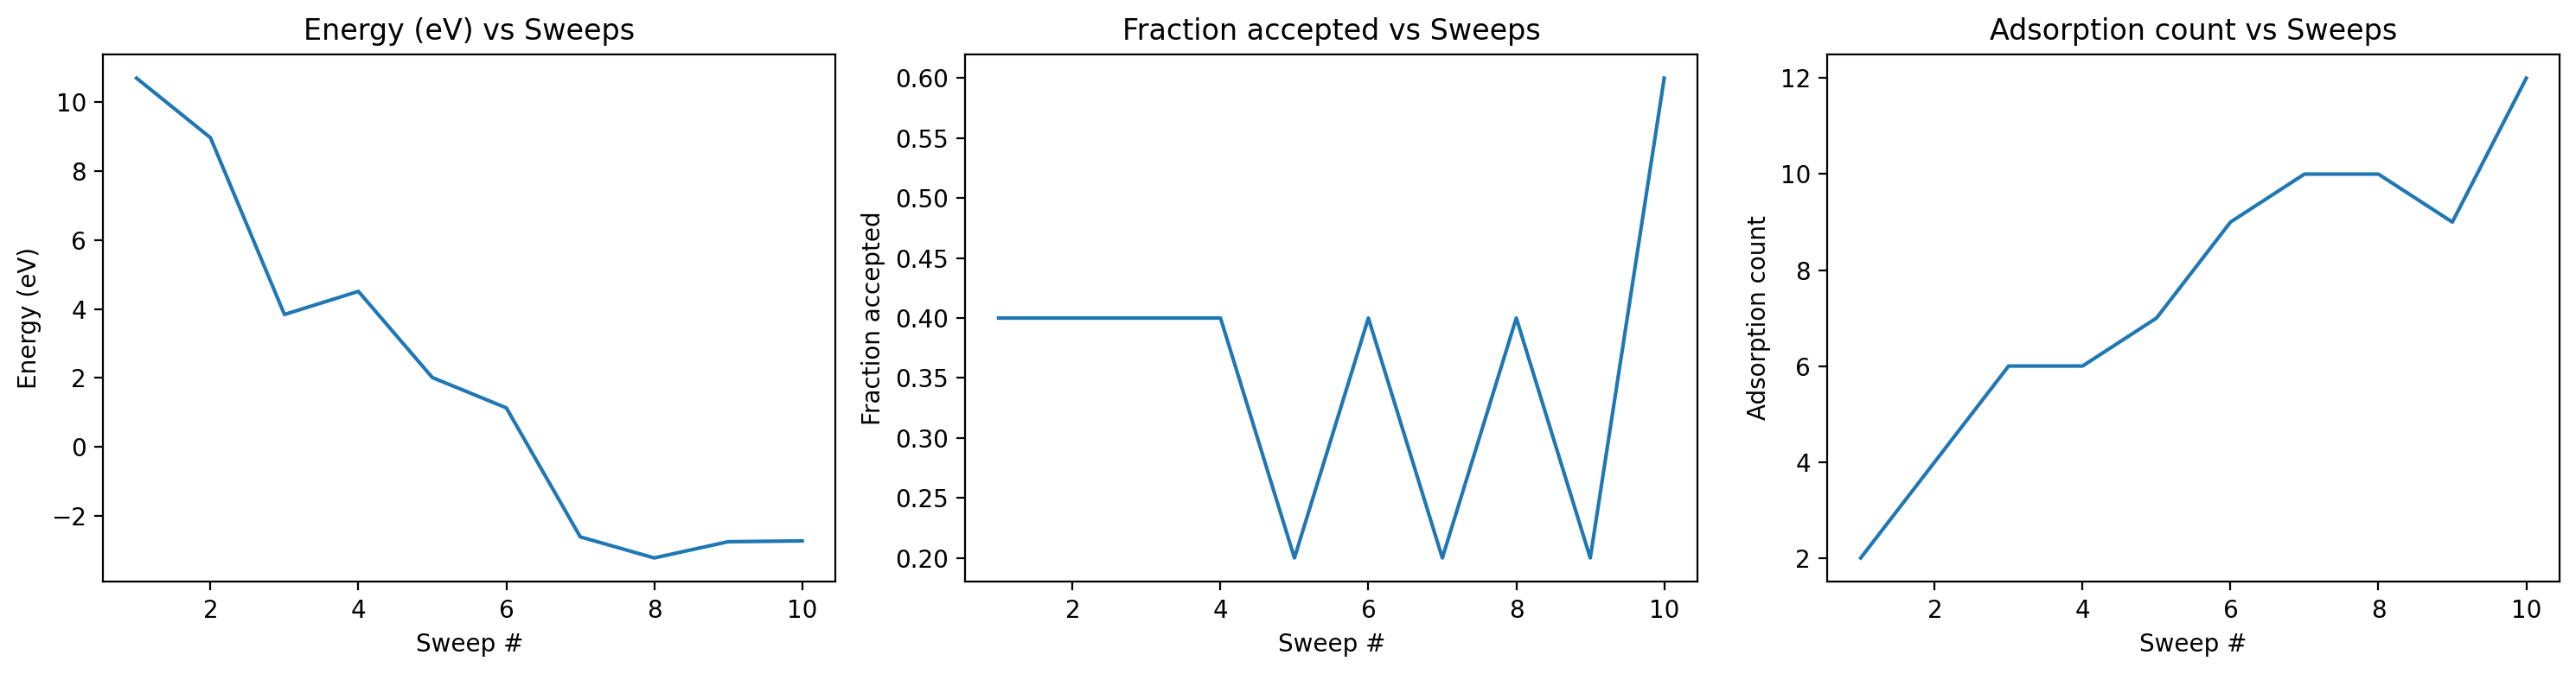

In [10]:
mcmc = MCMC(
    system_settings["surface_name"],
    calc=nff_surf_calc,
    canonical=False,
    testing=False,
    element=element,
    adsorbates=list(calc_settings["chem_pots"].keys()),
    relax=calc_settings["relax_atoms"],
    relax_steps=calc_settings["relax_steps"],
    offset=calc_settings["offset"],
    offset_data=calc_settings["offset_data"],
    optimizer=calc_settings["optimizer"],
)  # relax atoms with manual offset TODO fix this!

start = perf_counter()
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings["num_sweeps"],
    sweep_size=sampling_settings["sweep_size"],
    start_temp=sampling_settings["temperature"],
    pot=list(calc_settings["chem_pots"].values()),
    alpha=sampling_settings["alpha"],
    surface=surface,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

Save structures for later use in latent space clustering or analysis

In [11]:
structures = mcmc.history
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)